#### Treatment Comparison
Compare barcoded subpopulations of idling and untreated (control) SKMEL5 cells by their cell-cell distance in PCA space

In [1]:
# load files and packages
from fcc_utils import *
from fcc_DRs import *

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# reload functions when editing file
import sys
del sys.modules['fcc_DRs']
from fcc_DRs import *

Read in data files and associate barcodes with RNA counts

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 34.1 s, sys: 6.63 s, total: 40.8 s
Wall time: 43 s


Check out shape of counts matrices and barcode abundance

Untreated control: (2886, 25370)
Treated idling cells: (3524, 25370)


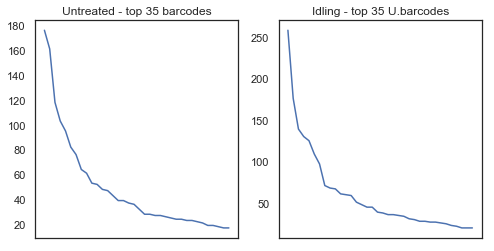

In [3]:
print('Untreated control: ' + str(U.data.shape))
print('Treated idling cells: ' + str(I.data.shape))

top35 = [x for x in range(1,36)]
plt.figure(figsize=(8,4))

plt.subplot(121)
U.barcode_counts(IDs=U.top_barcodes(top35)).plot()
plt.title('Untreated - top 35 barcodes')

plt.subplot(122)
I.barcode_counts(IDs=I.top_barcodes(top35)).plot()
plt.title('Idling - top 35 U.barcodes')

plt.show()

Using top 35 barcodes in __Untreated__ set, look at abundance in __Idling__ set

In [4]:
min(U.barcode_counts(IDs=U.top_barcodes(top35)))

17

In [5]:
min(I.barcode_counts(IDs=U.top_barcodes(top35)))

10

So, of the top 35 codes in the Untreated set, the lowest counts in the Idling set is 10, which is our cutoff.

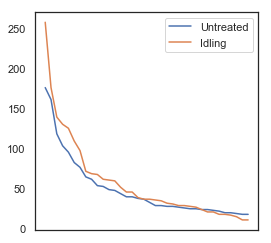

In [6]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
U.barcode_counts(IDs=U.top_barcodes(top35)).plot(label='Untreated', legend=True)
I.barcode_counts(IDs=U.top_barcodes(top35)).plot(label='Idling', legend=True)
plt.show()

Perform PCA on each dataset and plot selected barcodes

In [7]:
# first get list of codes to use throughout the rest of analysis
selected_codes = U.top_barcodes(top35)

In [13]:
%%time 
# perform PCA with 100 components on untreated cells, arcsinh-normalized
U_PCA = fcc_PCA(matrix=U.arcsinh_norm(), barcodes=U.barcodes, n_components=100)

CPU times: user 14 s, sys: 3.34 s, total: 17.3 s
Wall time: 12.7 s


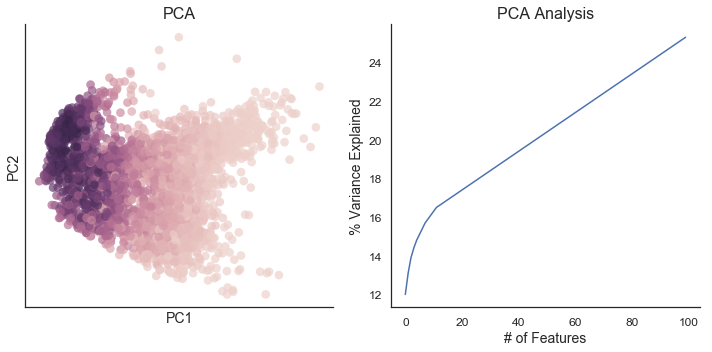

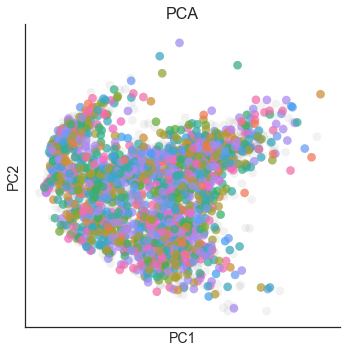

In [14]:
U_PCA.plot()
U_PCA.plot_barcodes(ranks=selected_codes)

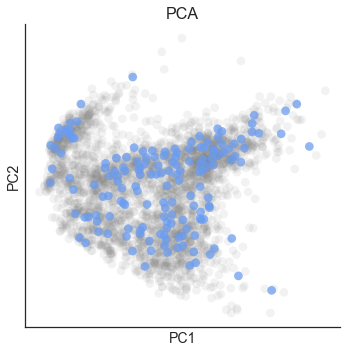

In [248]:
U_PCA.plot_barcodes(ranks=[selected_codes[1]])

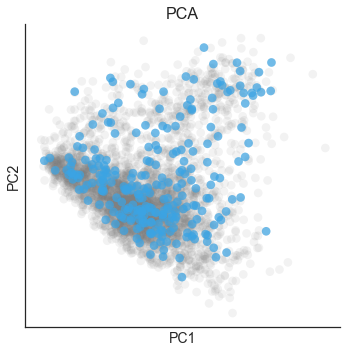

In [247]:
I_PCA.plot_barcodes(ranks=[selected_codes[1]])

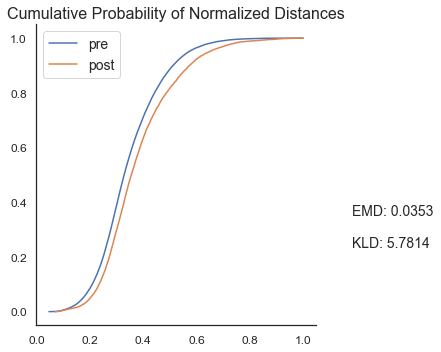

(0.03531886151211829, 5.781409716114517)

In [249]:
compare_distance_dist(pre=U_PCA.distance_matrix(ranks='all'), post=U_PCA.distance_matrix(ranks=[selected_codes[1]]))

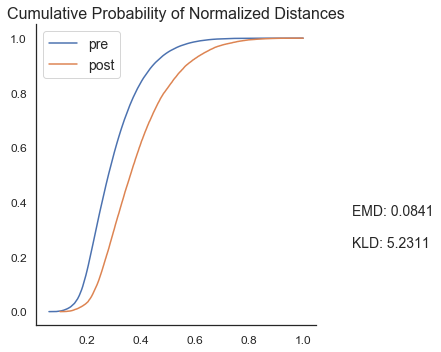

(0.08411781064101422, 5.231076731827255)

In [250]:
compare_distance_dist(pre=I_PCA.distance_matrix(ranks='all'), post=I_PCA.distance_matrix(ranks=[selected_codes[1]]))

In [17]:
%%time 
# perform PCA with 100 components on idling cells, arcsinh-normalized
I_PCA = fcc_PCA(matrix=I.arcsinh_norm(), barcodes=I.barcodes, n_components=100)

CPU times: user 17.6 s, sys: 3.11 s, total: 20.7 s
Wall time: 15.1 s


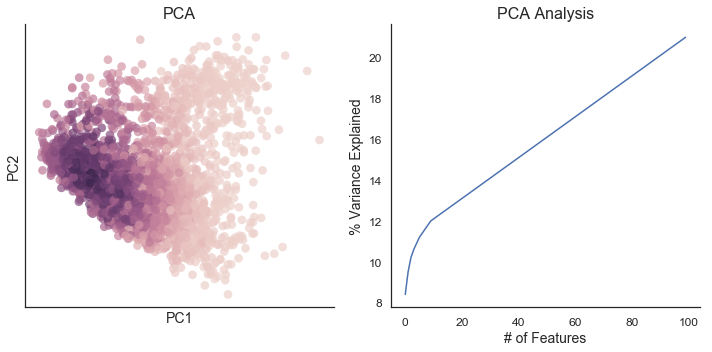

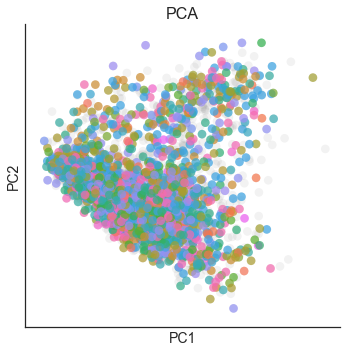

In [18]:
I_PCA.plot()
I_PCA.plot_barcodes(selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

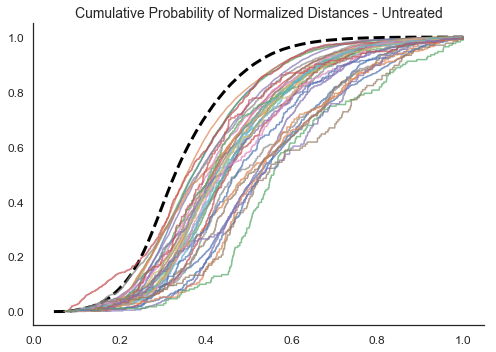

CPU times: user 54.8 s, sys: 2.13 s, total: 56.9 s
Wall time: 58 s


In [19]:
%%time
pre = U_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_PCA.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

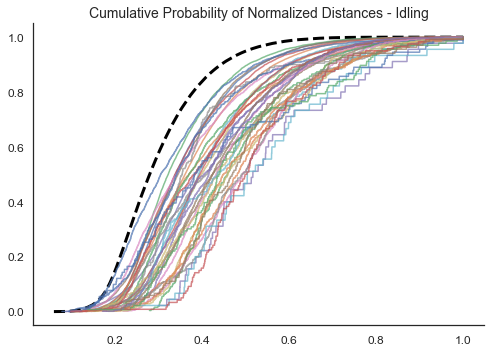

CPU times: user 1min 24s, sys: 2.88 s, total: 1min 27s
Wall time: 1min 30s


In [20]:
%%time
pre = I_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram(pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum(pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

I_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = I_PCA.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    I_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Idling', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

I_out = pd.DataFrame(I_out)

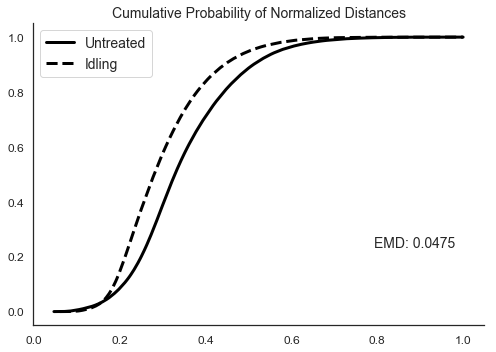

CPU times: user 10.5 s, sys: 1.68 s, total: 12.2 s
Wall time: 12.2 s


In [21]:
%%time
pre = U_PCA.distance_matrix(ranks='all') # null is whole untreated population
post = I_PCA.distance_matrix(ranks='all')

pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

# take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
post_flat = post[np.triu_indices(post.shape[1],1)]
# normalize flattened distances within each set for fair comparison of probability distributions
post_flat_norm = (post_flat/post_flat.max())

# calculate EMD for the distance matrices
EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
# Kullback Leibler divergence
# add very small number to avoid dividing by zero
KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram(pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum(pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label='Untreated', linestyle='solid', linewidth=3, color='black')

post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
post_cdf = np.cumsum(post_counts) 
plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label='Idling', linestyle='dashed', linewidth=3, color='black')

plt.title('Cumulative Probability of Normalized Distances', fontsize=14)
plt.figtext(0.75, 0.3, 'EMD: {}'.format(round(EMD,4)), fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
Now, we want to generate statistical confidence in the "noise" or tolerance for EMD using random subsampling for calculation of EMD from the null population.

In [22]:
# first, how many cells do we have in each barcode, expressed as the median?
print(np.median(U.barcode_counts(IDs=selected_codes)))
print(np.median(I.barcode_counts(IDs=selected_codes)))

34.0
36.0


In [23]:
# so we want 35 cells in each of our random samples. 
U_PCA.results.shape[0]/35

82.45714285714286

82-fold split for __Untreated__ 

In [24]:
I_PCA.results.shape[0]/35

100.68571428571428

100-fold split for __Idling__ 

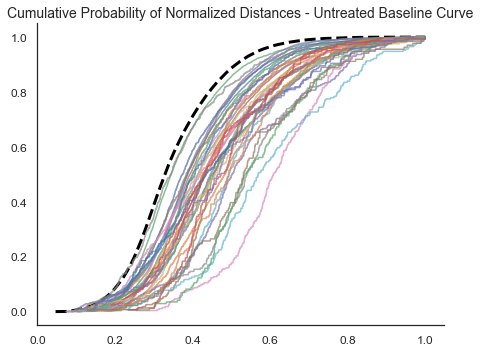

CPU times: user 54.9 s, sys: 1.88 s, total: 56.8 s
Wall time: 57.2 s


In [123]:
%%time 
# first, Untreated population:
pre = U_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_baseline_out = [] # initate list to make df of EMD and KLD from

for test_i in U.barcode_counts(selected_codes):
    U_rand = U_PCA.results[np.random.choice(U_PCA.results.shape[0], test_i, replace=False),]
    post = sc.spatial.distance_matrix(U_rand, U_rand)
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_baseline_out.append({'n_cells':test_i, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated Baseline Curve', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_baseline_out = pd.DataFrame(U_baseline_out)

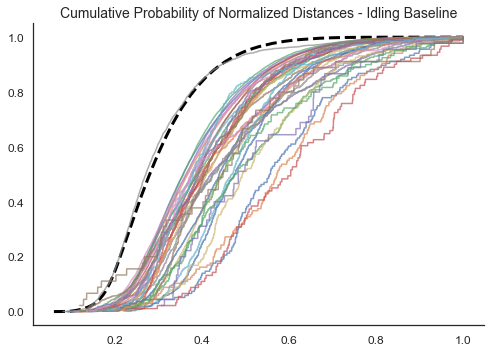

CPU times: user 1min 23s, sys: 2.6 s, total: 1min 26s
Wall time: 1min 27s


In [124]:
%%time 
# next, Idling population:
pre = I_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

I_baseline_out = [] # initate list to make df of EMD and KLD from

for test_i in I.barcode_counts(selected_codes):
    I_rand = I_PCA.results[np.random.choice(I_PCA.results.shape[0], test_i, replace=False),]
    post = sc.spatial.distance_matrix(I_rand, I_rand)
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    I_baseline_out.append({'split':test_i, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Idling Baseline', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

I_baseline_out = pd.DataFrame(I_baseline_out)

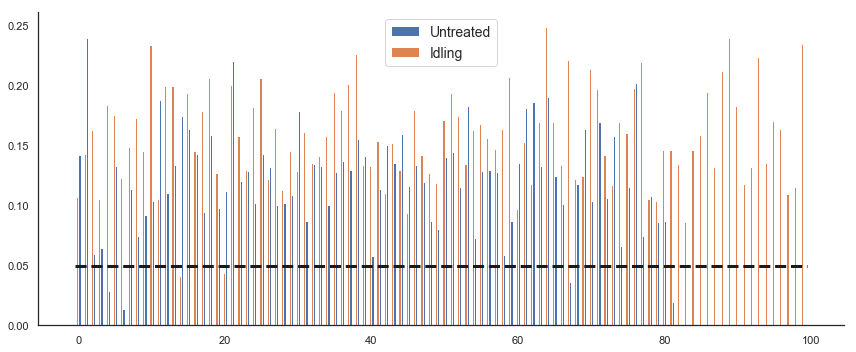

In [101]:
plt.figure(figsize=(12,5))
plt.bar(x=U_baseline_out.index, height=U_baseline_out.EMD, align='edge', width=0.3, label='Untreated')
plt.bar(x=I_baseline_out.index, height=I_baseline_out.EMD, align='edge', width=-0.3, label='Idling')
plt.hlines(y=0.0492, xmin=-0.5, xmax=len(I_baseline_out.index)-0.5, linestyle='dashed', linewidth=3)
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

Plot EMDs against calculated confidence intervals

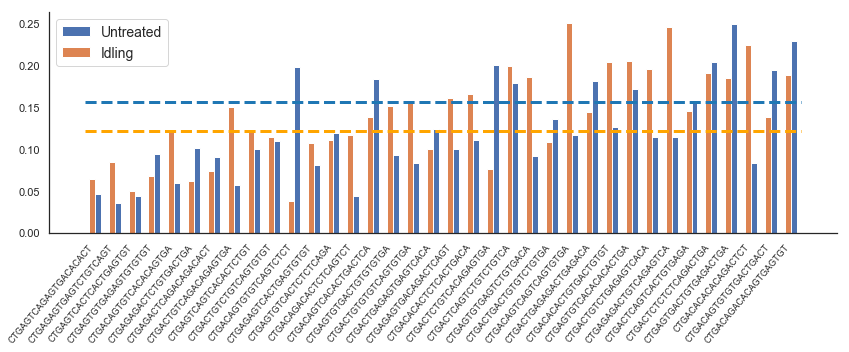

In [111]:
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.3, label='Untreated')
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.3, label='Idling')
plt.hlines(y=0.1211, xmin=-0.5, xmax=len(U_out.code)-0.5, linestyle='dashed', linewidth=3, color='orange')
plt.hlines(y=0.1561, xmin=-0.5, xmax=len(I_out.code)-0.5, linestyle='dashed', linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

Need to correct for number of cells in each barcode, and bias in EMD compared to whole population. The acceptance criteria line should be fit to number of cells and have some growing uncertainty around it.

In [144]:
%%time 
# first, Untreated population:
pre = U_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

U_baseline_curve = []
for rep in np.arange(1,11):
    U_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(10, 261, 10):
        U_rand = U_PCA.results[np.random.choice(U_PCA.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(U_rand, U_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        U_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        U_baseline_curve = pd.DataFrame({'n_cells':np.arange(10, 261, 10), 'EMD1':U_EMD})
        
    else:
        U_baseline_curve['EMD{}'.format(rep)] = U_EMD

CPU times: user 6min 16s, sys: 13.2 s, total: 6min 29s
Wall time: 6min 45s


In [198]:
myfit = np.poly1d(np.polyfit(U_baseline_curve.melt(id_vars='n_cells')['n_cells'],U_baseline_curve.melt(id_vars='n_cells')['value'], 3))


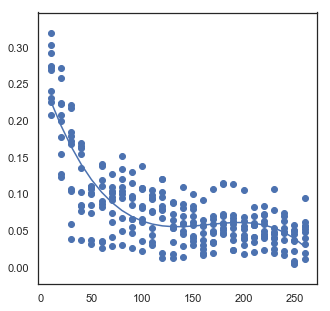

In [199]:
plt.figure(figsize=(5,5))
plt.scatter(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], y=U_baseline_curve.melt(id_vars='n_cells')['value'])
plt.plot(np.arange(10, 261, 10), myfit(np.arange(10, 261, 10)))
plt.show()

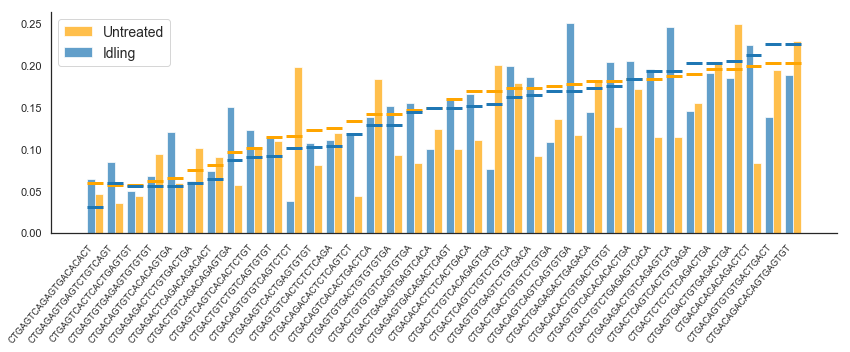

In [223]:
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=myfit(U.barcode_counts(selected_codes)), xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=myfit(I.barcode_counts(selected_codes)), xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()